Number of centers: 2, Points covered: 0


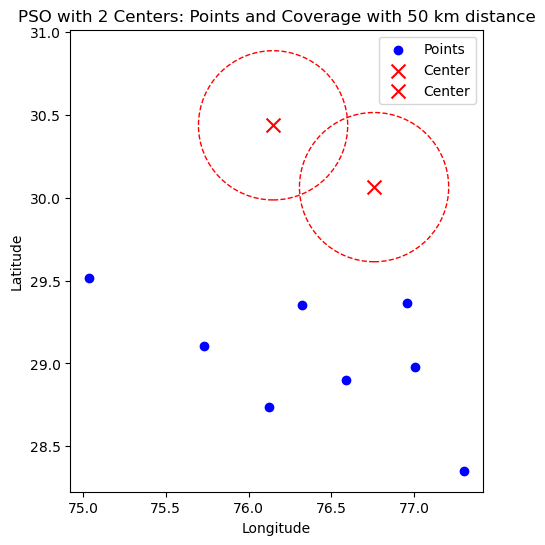

Number of centers: 3, Points covered: 1


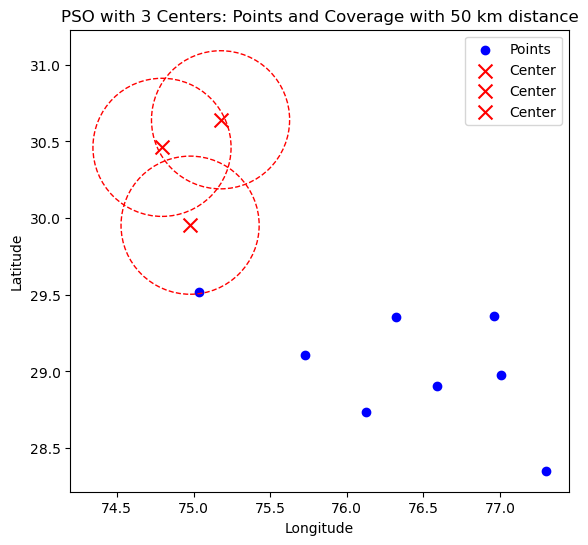

Number of centers: 4, Points covered: 1


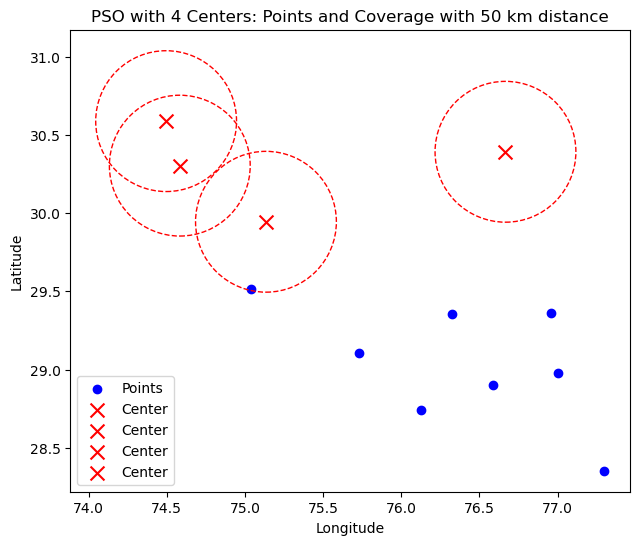

Number of centers: 5, Points covered: 1


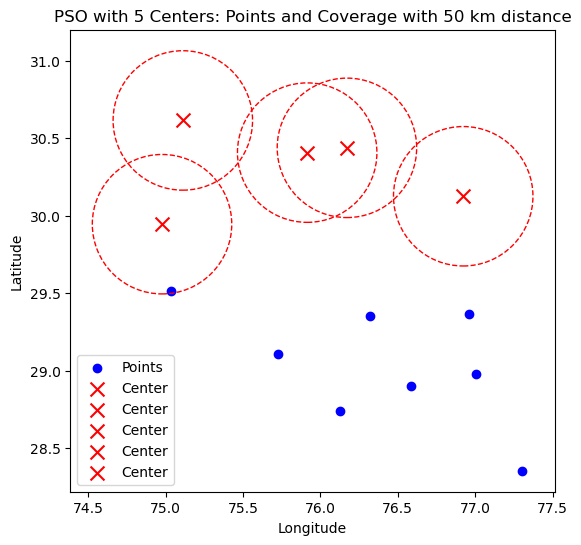

Number of centers: 6, Points covered: 1


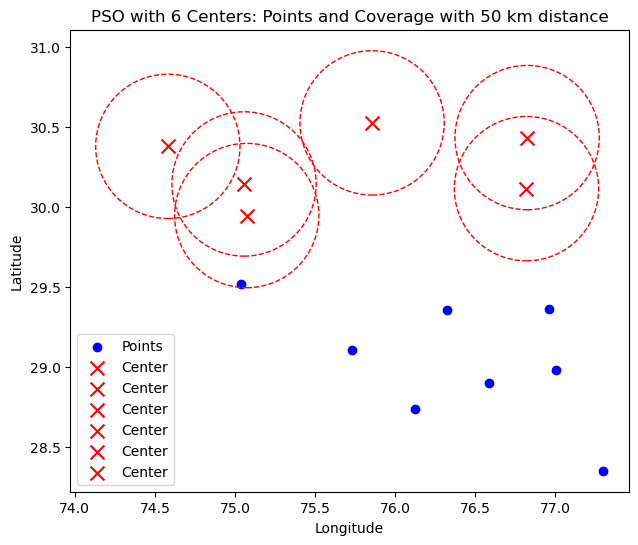

Number of centers: 7, Points covered: 1


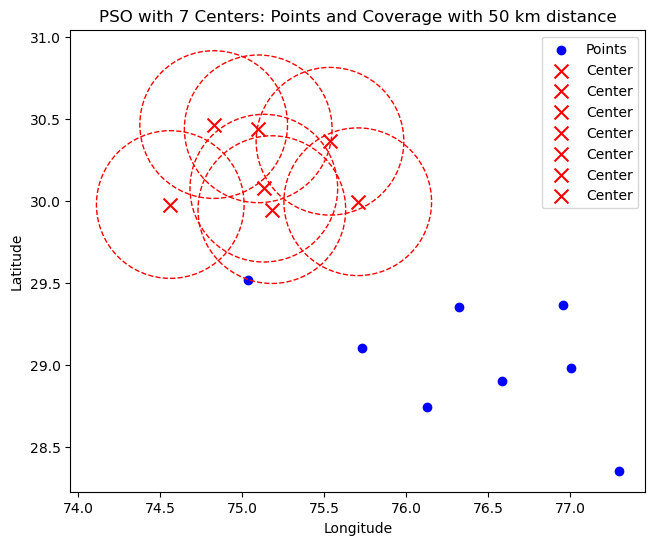

Number of centers: 8, Points covered: 1


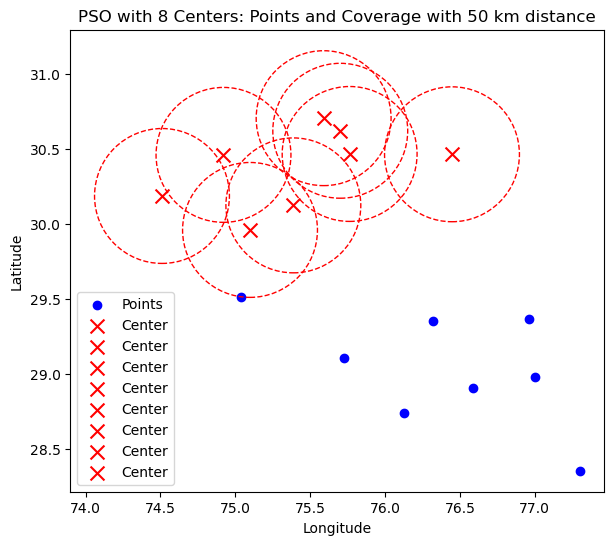

Number of centers: 9, Points covered: 1


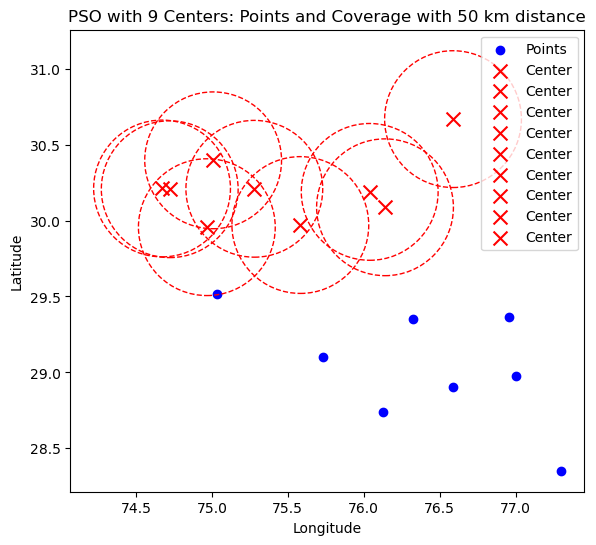

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Function to convert DMS to decimal degrees
def dms_to_dd(degrees, minutes, seconds):
    return degrees + (minutes / 60.0) + (seconds / 3600.0)

# Function to calculate the Haversine distance between two points in kilometers
def haversine(coord1, coord2):
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # Earth radius in kilometers
    r = 6371.0
    return r * c

# Function to check if a point is within the given distance from another point using Haversine formula
def covers(point, target, distance):
    return haversine(point, target) <= distance

# PSO Parameters
num_iterations = 5000  # Number of iterations to run the PSO
w = 0.5  # Inertia weight
c1 = 1.5  # Cognitive (particle) weight
c2 = 1.5  # Social (swarm) weight

# Function to evaluate fitness of a particle
def fitness(particle, data, distance):
    return np.sum([covers(particle, point, distance) for point in data])

# PSO Algorithm to find the best center
def pso(data, bounds, distance, num_particles, num_iterations):
    # Initialize particles
    particles = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=(num_particles, 2))
    velocities = np.random.uniform(low=-1, high=1, size=(num_particles, 2))

    # Initialize personal bests and global best
    p_best = particles.copy()
    p_best_fitness = np.array([fitness(p, data, distance) for p in particles])
    g_best = p_best[np.argmax(p_best_fitness)]
    g_best_fitness = np.max(p_best_fitness)

    # PSO iterations
    for _ in range(num_iterations):
        for i in range(num_particles):
            # Update velocity
            velocities[i] = (w * velocities[i]
                             + c1 * np.random.rand() * (p_best[i] - particles[i])
                             + c2 * np.random.rand() * (g_best - particles[i]))
            # Update particle position
            particles[i] += velocities[i]
            # Boundary conditions
            particles[i] = np.clip(particles[i], [bounds[0], bounds[2]], [bounds[1], bounds[3]])

            # Update personal best
            current_fitness = fitness(particles[i], data, distance)
            if current_fitness > p_best_fitness[i]:
                p_best[i] = particles[i]
                p_best_fitness[i] = current_fitness

                # Update global best
                if current_fitness > g_best_fitness:
                    g_best = particles[i]
                    g_best_fitness = current_fitness

    return g_best, g_best_fitness

# Define the bounds for the search space in decimal degrees
bounds = [
    dms_to_dd(29, 56, 43), dms_to_dd(30, 42, 48),  # Latitude bounds
    dms_to_dd(74, 29, 14), dms_to_dd(77, 10, 4)   # Longitude bounds
]

# Define the data points (converted to decimal degrees)
data = np.array([
    [dms_to_dd(29, 6, 15), dms_to_dd(75, 43, 43)],
    [dms_to_dd(29, 30, 57), dms_to_dd(75, 2, 11)],
    [dms_to_dd(29, 21, 12), dms_to_dd(76, 19, 19)],
    [dms_to_dd(28, 44, 19), dms_to_dd(76, 7, 27)],
    [dms_to_dd(28, 54, 8), dms_to_dd(76, 35, 8)],
    [dms_to_dd(28, 58, 45), dms_to_dd(77, 0, 11)],
    [dms_to_dd(29, 21, 46), dms_to_dd(76, 57, 33)],
    [dms_to_dd(28, 21, 9), dms_to_dd(77, 17, 59)]
])

# Set the distance for coverage in kilometers
distance = 50  # Assuming 150 km for the coverage radius

# Function to check overall coverage of a set of centers
def overall_coverage(centers, data, distance):
    covered_points = []
    for center in centers:
        covered_points.extend([point for point in data if covers(center, point, distance)])
    covered_points = np.unique(covered_points, axis=0)
    return len(covered_points)

# Iterate over different numbers of particles/centers
for num_centers in range(2, 10):
    # Initialize the uncovered points
    uncovered = data.copy()
    centers = []

    # Find the best centers using PSO
    for _ in range(num_centers):
        best_point, _ = pso(uncovered, bounds, distance, num_centers, num_iterations)
        centers.append(best_point)
        covered_points = [target for target in uncovered if covers(best_point, target, distance)]
        uncovered = np.array([point for point in uncovered if not any(np.array_equal(point, covered) for covered in covered_points)])

    # Calculate overall coverage
    coverage = overall_coverage(centers, data, distance)

    # Output the results
    print(f"Number of centers: {num_centers}, Points covered: {coverage}")

    # Plotting the points, centers, and circles
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 1], data[:, 0], c='blue', label='Points')
    for center in centers:
        plt.scatter(center[1], center[0], c='red', marker='x', s=100, label='Center')
        circle = plt.Circle((center[1], center[0]), distance / 111, color='r', fill=False, linestyle='--')
        plt.gca().add_patch(circle)

    plt.legend()
    plt.title(f'PSO with {num_centers} Centers: Points and Coverage with {distance} km distance')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

